## MLS WiSe 2025/26 Exercise 2.1: CIFAR‑10 Simple CNN (20P)
#### Adapted from an exercise created by Dennis Eisermann
In this notebook you will build, train and evaluate a basic convolutional‑neural‑network classifier on the CIFAR‑10 dataset using PyTorch. Read the instructions in each task cell and fill in the code.


### Task 1 – Local Setup (0P)
(alternatively: use "Jupyter PyTorch" Profile on bwJupyter)

* Install/import the libraries [torch](https://pytorch.org/get-started/locally/) and torchvision. Print the versions. 
* Install on your local PC: CUDA for NVIDIA and ROCM for AMD graphic cards!

In [1]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

if torch.cuda.is_available() :
    print("Let's do some CUDA magic, since we got it!!!")
else:
    print("No love, love! CUDA ain't there.")


2.7.1+cu128
0.22.1+cu128
Let's do some CUDA magic, since we got it!!!


### Task 2 – Load & explore the CIFAR‑10 data (5P)

1. Configure preprocessing pipelines for training and testing with normalization and horizontal flip as augmentations. These pipelines benefit the quality of the training. (For normalization, you can take pre-computed mean/std from public sources for this dataset or calculate them youself.)
(2P)

For the discussion, not the submission: What is normalization good for and why should you do this horizontal flip?

In [2]:
from torchvision.transforms import v2

def normalize_cifar10():
    return v2.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
    
def horiziontal_flip():
    return v2.RandomHorizontalFlip(p=0.5)

What is normalization good for and why should you do this horizontal flip?

Answer:
Once the data is normalized you dont have to be so careful with optimazition steps width (learning rate). Allowing to use faster learning rates for faster achieving convergence. 
The horizontal flip is a cheap way to augment the data to double the amount of training data. 

2. Download the training and test splits from [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html). Create [Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) with a batch_size of 128 and random shuffling only for training.
Use the already defined preporcessing pipeline to transform the dataset. These datasets will be used to train and evaluate a neural network. (1P)

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.CIFAR10(
    root="./data",
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=128)

testloader = DataLoader(test_dataset, shuffle=False, batch_size=128)
 

3. Show 8 sample [images](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_demo.html) and their labels from test dataset. Use subplots from [Matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html).
The requested graphic  should show an impression of our dataset and the performed transformations. (2P)

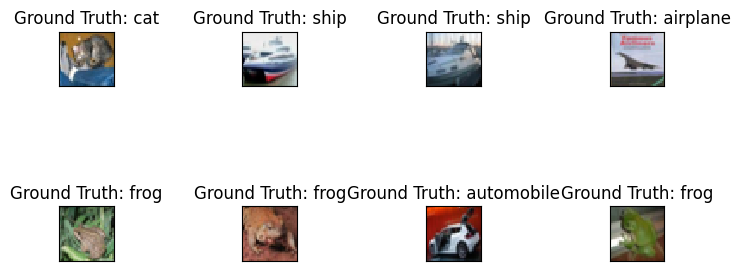

In [4]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
import matplotlib.pyplot as plt
import numpy


inputs = test_dataset.data[:8]
labels = test_dataset.targets[:8]
fig = plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.tight_layout(w_pad=7.0)
    plt.imshow(inputs[i,:,:,:], interpolation='none')
    plt.title("Ground Truth: {}".format(classes[int(labels[i])]))
    plt.xticks([])
    plt.yticks([])

### Task 3 – Build a simple CNN (5P)
Create a PyTorch `nn.Module` called `SimpleCNN`. A good [architecture](https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/) for CIFAR‑10:
* Conv(3→32) → ReLU → Conv(32→64) → ReLU → MaxPool(2)
* Conv(64→128) → ReLU → MaxPool(2)
* Flatten → Linear(128·8·8 → 256) → ReLU → Dropout(0.3) → Linear(256 → 10)

You define an image classifier neural network which takes 32x32 images as input and matches them to 10 output classes.
Instantiate the model and move it to *GPU if available*. Print the architecture.

For the discussion, not the submission: Why is this a reasonable architecture? Are there others you would try?

In [5]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32,1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,10))
    def forward(self, x): return self.fc(self.conv(x))
    

### Task 4 – Train the network (5P)
1. Create a *cross‑entropy loss* and  an *Adam* optimizer (learning‑rate 1e‑3) . The loss describes how much the result of the classifier differs from the labels of the training data.
The optimizer describes how much every wheight of the neural network will be adjusted in every step to move the prediction towards the training label. (1P)


In [6]:
import torch


training_net = SimpleCNN()
training_net.train()

if torch.cuda.is_available() :
    training_net.to('cuda')

Optimizer = torch.optim.NAdam(training_net.parameters(), lr=1e-3)
Optimizer.zero_grad()

# Compute loss
loss_fn = nn.CrossEntropyLoss()

2. Load the data to the GPU. Train the CNN for 10 epochs. Print training and validation [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) for each epoch. [Saves](https://pytorch.org/tutorials/beginner/saving_loading_models.html) the best model weights to `cifar10_simplecnn.pth`.  (4P)

In [7]:
TRAINING_EPOCHS = 10

for epoch in range(TRAINING_EPOCHS):
    losses, accuracies = [], []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
 
        Optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = training_net.forward(inputs)
        loss = loss_fn(outputs, labels)
        print("Epoch {}, Iteration {}, Loss {:.4f}: ".format(epoch, i,loss))
        loss.backward()
        Optimizer.step()
        
    
Optimizer.zero_grad()

Epoch 0, Iteration 0, Loss 2.3059: 
Epoch 0, Iteration 1, Loss 2.3550: 
Epoch 0, Iteration 2, Loss 2.3031: 
Epoch 0, Iteration 3, Loss 2.3148: 
Epoch 0, Iteration 4, Loss 2.3084: 
Epoch 0, Iteration 5, Loss 2.3064: 
Epoch 0, Iteration 6, Loss 2.3045: 
Epoch 0, Iteration 7, Loss 2.2941: 
Epoch 0, Iteration 8, Loss 2.2855: 
Epoch 0, Iteration 9, Loss 2.3011: 
Epoch 0, Iteration 10, Loss 2.2771: 
Epoch 0, Iteration 11, Loss 2.2923: 
Epoch 0, Iteration 12, Loss 2.2756: 
Epoch 0, Iteration 13, Loss 2.2543: 
Epoch 0, Iteration 14, Loss 2.2775: 
Epoch 0, Iteration 15, Loss 2.2596: 
Epoch 0, Iteration 16, Loss 2.2422: 
Epoch 0, Iteration 17, Loss 2.1973: 
Epoch 0, Iteration 18, Loss 2.2214: 
Epoch 0, Iteration 19, Loss 2.2512: 
Epoch 0, Iteration 20, Loss 2.2572: 
Epoch 0, Iteration 21, Loss 2.2330: 
Epoch 0, Iteration 22, Loss 2.2037: 
Epoch 0, Iteration 23, Loss 2.2123: 
Epoch 0, Iteration 24, Loss 2.2498: 
Epoch 0, Iteration 25, Loss 2.1828: 
Epoch 0, Iteration 26, Loss 2.1800: 
Epoch 0, It

### Task 5 – Test an image & interpret results (5P)
1. Load the model with the saved weights to the GPU and put it in evaluation mode so we can use the model for inference. (1P)

In [8]:
import os
import torch

def save(training_net, directory: str, name: str):
        """Stores the current state and config of the agent"""
        os.makedirs(directory, exist_ok=True)
        path = os.path.join(directory, f'{name}.pt')
        torch.save(training_net,path)
        
       
save(training_net, "./models", "simple_cnn_cifar10")
        
training_net.eval()

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

2. Take the first image from the *test* set and infer its class to see if the classifier was loaded properly. (2P)

In [9]:

loaded_model = torch.load("./models/simple_cnn_cifar10.pt", weights_only=False)
first_image = test_dataset.data[:1]  # Shape (1, 32, 32, 3)

# To Tensor 
first_image_tensor = torch.from_numpy(first_image).permute(0, 3, 1, 2).float() / 255.0  # -> (1, 3, 32, 32)

# Normalize again
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)
first_image_tensor = normalize(first_image_tensor[0]).unsqueeze(0)  # Normalisierung + Batch-Dim

# To GPU (Maybe needed? TODO when  )
device = next(loaded_model.parameters()).device
first_image_tensor = first_image_tensor.to(device)

# Inference
loaded_model.eval()
with torch.no_grad():
    output = loaded_model(first_image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

    loaded_model.softmax = torch.nn.Softmax(dim=1)
    probabilities = loaded_model.softmax(output)
    confidence_value = probabilities[0, predicted_class].item() * 100
    

3. Display the image alongside the predicted label with its confidence as well as the label from the dataset. This visualizes the capability of the classifier to make a right decision. (2P)

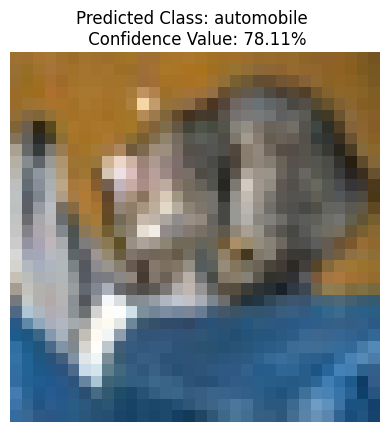

In [10]:
plt.imshow(first_image[0])
plt.title("Predicted Class: {} \n Confidence Value: {:.2f}%".format(classes[int(predicted_class)], confidence_value))
plt.axis('off');
